# Projekt Autoenkoder
Indeks: 145317

Wymagania:
- stworzenie sieci neuronowej typu autoencoder
- dane wejściowe to obrazy czarno-białe (1 kanał)
- dane wyjściowe to obrazy kolorowe (3 kanały)
- badanie różnych rozmiarów sieci neuronowej
- badanie wpływu poszczególnych elementów regularyzacji na wynik:
  - wpływ parametru momentum oraz rozmiaru batcha przy wykorzystaniu batch normalization
  - wpływ dropout rate
  - wpływ weight decay

Zrealizowane przy wykorzystaniu bibliotek:
- Pytorch — Tworzenie i nauka sieci neuronowej.
- Matplotlib -- Wizualizacja.
- cv2 - open-cv -- Obróbka obrazów.

Wykorzystany dataset:
- [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) -- Zbiór 50000 obrazów treningowych i 10000 testowych.


## Preludium

In [1]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import backend as K

import cv2
import numpy as np
import matplotlib.pyplot as plt

2023-01-17 01:09:20.383837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import functools

def pipe(*fns):
  return functools.reduce(lambda f, g: lambda x: f(g(x)), reversed(fns))

import sys
sys

## Sprawdzenie dostępności GPU

In [3]:
import tensorflow as tf

tf.config.list_physical_devices('GPU') and 'GPU is available' or "GPU is not available"
print(169)

169


2023-01-17 01:09:51.468820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 01:09:51.484180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 01:09:51.484374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Załadowanie bazy obrazów Cifar100 oraz wykonanie preprocesów.
- Baza obrazów:
  - [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) -- Zbiór 50000 obrazów treningowych i 10000 testowych.
- Preprocesy:
  - Zamiana przestrzeni z 1-255 python-int na 0-1 float32.
  - Zamiana obrazu kolorowego na obraz szary.
  - Rozszerzenie kształtu obrazu szarego na kształt kompatybilny z wejściem sieci.

In [4]:
def rgb2gray(rgb):
  return cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

def load_datasets():
  print("Loading train dataset...")
  print("Loading test dataset...")
  (y_train, _), (y_test, _) = cifar100.load_data()
  print("Preparing train dataset...")
  y_train = y_train.astype('float32') / 255
  x_train = np.expand_dims([rgb2gray(x) for x in y_train], axis=3)
  print("Preparing test dataset...")
  y_test = y_test.astype('float32') / 255
  x_test = np.expand_dims([rgb2gray(x) for x in y_test], axis=3)
  print("Finished.")
  return (x_train, y_train), (x_test, y_test)
(x_train, y_train), (x_test, y_test) = load_datasets()

Loading train dataset...
Loading test dataset...
Preparing train dataset...
Preparing test dataset...
Finished.


## Prezentacja przykładowych obrazów z datasetu.

In [5]:
def compare(original, grayscale=None):
  if grayscale is None: grayscale = rgb2gray(original)

  figure, axes = plt.subplots(1, 2)
  axes[0].set_title("Original")
  axes[0].grid(False)
  axes[0].set_axis_off()
  axes[0].imshow(original)
  axes[1].set_title("Grayscale")
  axes[1].grid(False)
  axes[1].set_axis_off()
  axes[1].imshow(grayscale, cmap='gray')

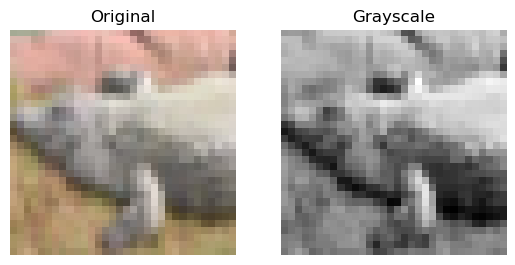

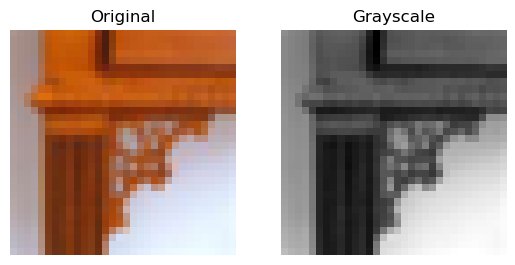

In [6]:
index = np.random.randint(2, len(y_train) - 1)
for original in y_train[index - 2:index]: compare(original)

### Prezentacja kolażu obrazów.

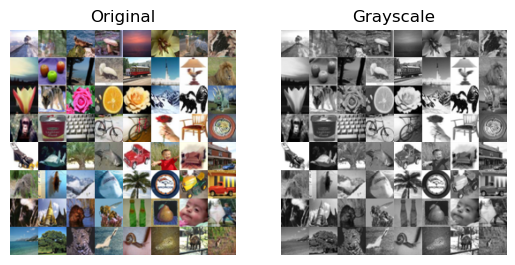

In [7]:
def square_collage(images, size: int = 8):
  (_, rows, cols, channels) = images.shape
  collage = images[:size * size]
  collage = collage.reshape((size, size, rows, cols, channels))
  return np.vstack([*map(np.hstack, collage)])

compare(square_collage(y_test), square_collage(x_test))

## Konstrukcja modelu sieci autoencoder.
- Konstrukcja sieci jst sparametryzowana o możliwość wprowadzenia:
  - use_normalization: bool -- batch normalization.
  - use_dropout: bool | float -- wykorzystanie dropout'u.
- Podczas trenowania sieci również są dostępne opcje:
  - use_weight_decay: float -- wykorzystanie weight decay podczas nauki.

### Model 'Encoder'.

In [11]:
def create_encoder(layers_filters, use_normalization= False, use_dropout= False):
  inputs = Input(shape=(32, 32, 1), name='encoder-input')
  x = inputs
  for filters in layers_filters:
    x = Conv2D(filters=filters,
               kernel_size=3,
               strides=2,
               activation='relu',
               padding='same')(x)
    if use_normalization:
      x = BatchNormalization()(x)
    if use_dropout:
      x = Dropout(use_dropout)(x)
  # Obliczenie kształtu przed sieci, aby nie musieć jej manualnie przeliczać.
  shape = K.int_shape(x)

  # Generacja zmiennej utajonej
  x = Flatten()(x)
  latent = Dense(256, name='latent-vector')(x)
  return Model(inputs, latent, name='encoder'), shape

### Model 'Decoder'.

In [12]:
def create_decoder(layers_filters, shape):
  inputs = Input(shape=(256,), name='decoder-input')
  x = Dense(shape[1] * shape[2] * shape[3])(inputs)
  x = Reshape((shape[1], shape[2], shape[3]))(x)

  for filters in reversed(layers_filters):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=3,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

  outputs = Conv2DTranspose(filters=3,
                            kernel_size=3,
                            activation='sigmoid',
                            padding='same',
                            name='decoder-output')(x)
  return Model(inputs, outputs, name='decoder')

### Podsumowanie enkodera i dekodera

In [13]:
layers_filters = [64, 128]
(encoder, shape) = create_encoder(layers_filters)
encoder.summary()
decoder = create_decoder(layers_filters, shape)
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder-input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent-vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1,418,496
Trainable params: 1,418,496
Non-tra

2023-01-17 01:10:34.391742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 01:10:34.392991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 01:10:34.393195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 01:10:34.393342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUM

### Podsumowanie autoenkodera

In [14]:
def create_autoencoder(layers_filters, use_normalization=None, use_dropout=None):
  inputs = Input(shape=(32, 32, 1), name='encoder-input')
  (encoder, shape) = create_encoder(layers_filters, use_normalization, use_dropout)
  decoder = create_decoder(layers_filters, shape)

  return Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder = create_autoencoder(layers_filters)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder-input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               1418496   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


### Training callbacks
- ReduceLROnPlateau - reduces lr by given value 0.1**0.5 every 3 epochs without improvement.
- ModalCheckpoint - saves model to given path every improved epoch.

### Training the network

In [15]:
import tensorflow_addons as tfa
def train_model(model, weight_decay=0, savename=None):
  callbacks = [
    ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-6),
    ModelCheckpoint(filepath=f'models/{savename}.h5', monitor='val_loss', save_best_only=True)
  ]

  optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=weight_decay)

  model.compile(loss='mse', optimizer=optimizer)
  return model.fit(x_train, y_train, validation_data=(x_test, y_test),
                   epochs=20, batch_size=16, callbacks=callbacks)

histories = train_model(autoencoder)

Epoch 1/20


2023-01-17 01:10:56.408516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-01-17 01:10:56.674131: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


3125/3125 [==============================] - 37s 11ms/step - loss: 0.0182 - val_loss: 0.0146 - lr: 0.0010
Epoch 2/20
3125/3125 [==============================] - 35s 11ms/step - loss: 0.0137 - val_loss: 0.0134 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - 35s 11ms/step - loss: 0.0128 - val_loss: 0.0130 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - 35s 11ms/step - loss: 0.0122 - val_loss: 0.0123 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - 35s 11ms/step - loss: 0.0118 - val_loss: 0.0121 - lr: 0.0010
Epoch 6/20
3125/3125 [==============================] - 35s 11ms/step - loss: 0.0114 - val_loss: 0.0121 - lr: 0.0010
Epoch 7/20
3125/3125 [==============================] - 36s 12ms/step - loss: 0.0111 - val_loss: 0.0123 - lr: 0.0010
Epoch 8/20
3125/3125 [==============================] - 37s 12ms/step - loss: 0.0108 - val_loss: 0.0116 - lr: 0.0010
Epoch 9/20
3125/3125 [==============================] - 36s 12ms/step - los

### Predict using autoencoder

In [16]:
predicted = autoencoder.predict(x_test)

313/313 [==============================] - 2s 5ms/step


## Results side by side
### Multiple

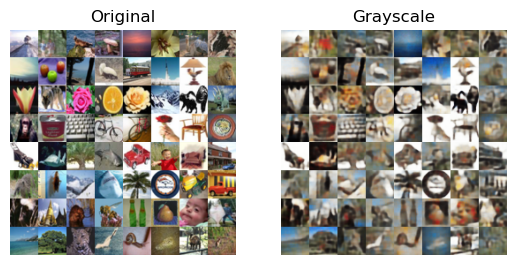

In [17]:
compare(square_collage(y_test), square_collage(predicted))

### Single Image

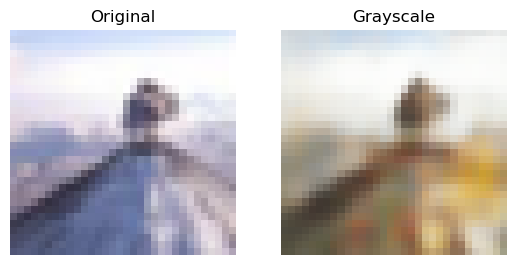

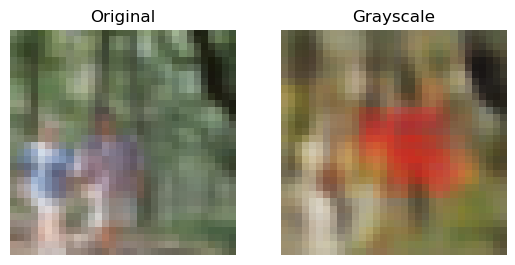

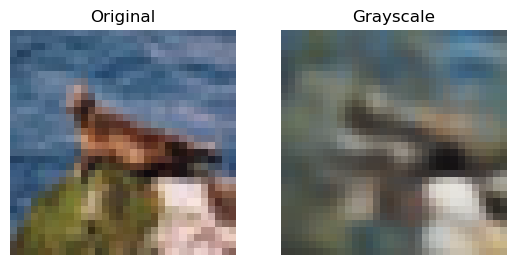

In [18]:
for (original, prediction) in zip(y_test[:3], predicted[:3]): compare(original, prediction)

## Badania wpływu parametrów na wyjście i parametry walidujące.
Sieć kontrolna to:
Sieć bez dropout, bez normalizacji batch'y, bez weight decay oraz o rozmiarze filtrów warstw [64, 128]

(<keras.engine.functional.Functional object at 0x7fcf021e7820>, <keras.engine.functional.Functional object at 0x7fcf021e7820>, <keras.engine.functional.Functional object at 0x7fcf021e7820>) (<keras.callbacks.History object at 0x7fceacbd7310>, <keras.callbacks.History object at 0x7fceacbd7310>, <keras.callbacks.History object at 0x7fceacbd7310>)


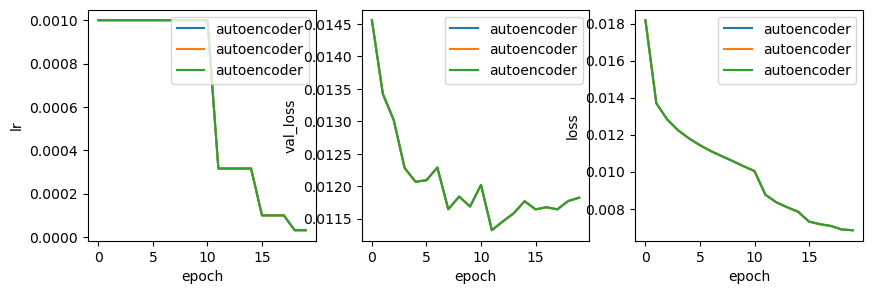

In [34]:
def plot_histories(*pairs, parameters):
  figure, axes = plt.subplots(ncols=len(parameters), figsize=(10, 3))
  (models, histories) = list(zip(*pairs))

  labels = [x.name for x in models]
  for axis, parameter in zip(axes.reshape(-1), parameters):
    for history in histories:
      axis.plot(history.history[parameter])
    axis.set_ylabel(parameter)
    axis.set_xlabel('epoch')
    axis.legend(labels, loc='upper right')
  plt.show()

# Przykładowy plot z parametrami learning_rate, val_loss oraz loss
plot_histories((autoencoder, histories), parameters=['lr', 'val_loss', 'loss'])

### Wpływ dropout rate.
- badane sieci:
  - Sieć I   -- Kontrolna | Brak
  - Sieć II  -- 0.05
  - Sieć III -- 0.15

In [35]:
layers = [64, 128]
basemodel = create_autoencoder(layers, use_dropout=0.00)
model_1 = create_autoencoder(layers, use_dropout=0.05)
model_2 = create_autoencoder(layers, use_dropout=0.15)

pairs = [
  (basemodel, train_model(basemodel, savename='dropout-0.00.{epoch:03d}')),
  (model_1, train_model(model_1, savename='dropout-0.05.{epoch:03d}')),
  (model_2, train_model(model_2, savename='dropout-0.15.{epoch:03d}')),
]
plot_histories(*pairs, parameters=['val_loss', 'loss', 'lr'])

Epoch 1/20
3125/3125 [==============================] - 37s 12ms/step - loss: 0.0182 - val_loss: 0.0146 - lr: 0.0010
Epoch 2/20
3125/3125 [==============================] - 36s 12ms/step - loss: 0.0137 - val_loss: 0.0134 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - 37s 12ms/step - loss: 0.0128 - val_loss: 0.0131 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - 37s 12ms/step - loss: 0.0122 - val_loss: 0.0123 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - 38s 12ms/step - loss: 0.0117 - val_loss: 0.0121 - lr: 0.0010
Epoch 6/20
3125/3125 [==============================] - 36s 12ms/step - loss: 0.0114 - val_loss: 0.0119 - lr: 0.0010
Epoch 7/20
3125/3125 [==============================] - 36s 12ms/step - loss: 0.0111 - val_loss: 0.0115 - lr: 0.0010
Epoch 8/20
3125/3125 [==============================] - 36s 12ms/step - loss: 0.0108 - val_loss: 0.0116 - lr: 0.0010
Epoch 9/20
3125/3125 [==============================] - 36s 12ms

2023-01-17 01:50:03.316213: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder/encoder/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3125/3125 [==============================] - 40s 13ms/step - loss: 0.0186 - val_loss: 0.0150 - lr: 0.0010
Epoch 2/20
3125/3125 [==============================] - 39s 13ms/step - loss: 0.0143 - val_loss: 0.0136 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - 39s 12ms/step - loss: 0.0134 - val_loss: 0.0130 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - 39s 12ms/step - loss: 0.0129 - val_loss: 0.0125 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - 41s 13ms/step - loss: 0.0124 - val_loss: 0.0123 - lr: 0.0010
Epoch 6/20
3125/3125 [==============================] - 39s 12ms/step - loss: 0.0121 - val_loss: 0.0123 - lr: 0.0010
Epoch 7/20
3125/3125 [==============================] - 39s 13ms/step - loss: 0.0118 - val_loss: 0.0118 - lr: 0.0010
Epoch 8/20
3125/3125 [==============================] - 40s 13ms/step - loss: 0.0116 - val_loss: 0.0120 - lr: 0.0010
Epoch 9/20
3125/3125 [==============================] - 39s 12ms/step - los

2023-01-17 02:03:29.037189: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 585.94MiB (rounded to 614400000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-01-17 02:03:29.037235: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-01-17 02:03:29.037247: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 114, Chunks in use: 113. 28.5KiB allocated for chunks. 28.2KiB in use in bin. 6.0KiB client-requested in use in bin.
2023-01-17 02:03:29.037255: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 22, Chunks in use: 22. 11.5KiB allocated for chunks. 11.5KiB in use in bin. 11.0KiB client-requested in use in bin.
2023-01-17 02:03:29.037262: I tensorflow/tsl/fr

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

29.038018: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at b04816100 of size 1024 next 43
2023-01-17 02:03:29.038021: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at b04816500 of size 1280 next 158
2023-01-17 02:03:29.038024: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at b04816a00 of size 2304 next 169
2023-01-17 02:03:29.038027: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at b04817300 of size 1024 next 171
2023-01-17 02:03:29.038030: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at b04817700 of size 512 next 175
2023-01-17 02:03:29.038033: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at b04817900 of size 256 next 177
2023-01-17 02:03:29.038036: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at b04817a00 of size 256 next 179
2023-01-17 02:03:29.038039: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at b04817b00 of size 256 next 137
2023-01-17 02:03:29.038042: I tensorflow/tsl/framework/bfc_allocator.c


### Wpływ weight decay.
- Do badania został wykorzystany rozszerzenie AdamW optymalizator Adama.
- badane sieci:
  - Sieć I   -- Kontrolna | Brak
  - Sieć II  -- 0.10
  - Sieć III -- 0.25

In [ ]:
layers = [64, 128]
basemodel = create_autoencoder(layers)
model_1 = create_autoencoder(layers)
model_2 = create_autoencoder(layers)

histories = [
  (basemodel, train_model(basemodel, weight_decay=0.00, savename='decay-0.00.{epoch:03d}')),
  (model_1, train_model(model_1, weight_decay=0.10, savename='decay-0.10.{epoch:03d}')),
  (model_2, train_model(model_2, weight_decay=0.25, savename='decay-0.25.{epoch:03d}'))
]
plot_histories(*histories, parameters=['val_loss', 'loss', 'lr'])

### Wpływ rozmiaru batch normalization.
- Do badania została wykorzystana gotowa wartswa z tensorflow.keras BatchNormalization.
- badane sieci:
  - Sieć I   -- Kontrolna | Brak
  - Sieć II  -- istnieje

In [ ]:
layers = [64, 128]
basemodel = create_autoencoder(layers, use_normalization=False)
model_1 = create_autoencoder(layers, use_normalization=True)

pairs = [
  (basemodel, train_model(basemodel, savename='batch-no.{epoch:03d}')),
  (model_1, train_model(model_1, savename='batch-yes.{epoch:03d}'))
]
plot_histories(*pairs, parameters=['val_loss', 'loss', 'lr'])

### Wpływ rozmiaru sieci.
- Do badania została wykorzystana gotowa wartswy z paczki tensorflow.keras.
- badane sieci:
  - Sieć I   -- Kontrolna | [64, 128]
  - Sieć II  -- [32, 64, 128]
  - Sieć III -- [32, 64, 128]

In [ ]:
basemodel = create_autoencoder([64, 128])
model_1 = create_autoencoder([32, 64, 128])
model_2 = create_autoencoder([32, 64])

pairs = [
  (basemodel, train_model(basemodel, savename='filters-medium.{epoch:03d}')),
  (model_1, train_model(model_1, savename='filters-bigger.{epoch:03d}')),
  (model_2, train_model(model_2, savename='filters-smaller.{epoch:03d}')),
]
plot_histories(*pairs, parameters=['val_loss', 'loss', 'lr'])

## Podsumowanie oraz Doświadczenia
Nie mogę przeprowadzić badania. Google collab, 25 minut na epokę, do odpalenia 9 sieci. 9 * 30 * 25 / 60 = 112.5. pierdolę tę polibud.
Nienawidzę tensorflow.
Wyrzucone w błoto 8 godzin na poprawianie ciągle wyrzucającej się infrastruktury.
Non-stop, koło nienawiści, działa przez 2 godziny i nagle przestaje, nie ilość vram, nie ilość instacji, nie wersja tensorflow, nie wersja cudnn.
Nie będę przeinstalowywać systemu operacyjnego na jeden Model.